In [92]:
# ---------------------- Import Necessary Libraries ---------------------- #
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from collections import Counter
import seaborn as sns
from wordcloud import WordCloud
from networkx.algorithms.community import greedy_modularity_communities
from textblob import TextBlob  # For sentiment analysis
print('Setup Complete')

Setup Complete


#### In this study we're going to use a dataset called "Interaction_Data.csv" which gives us some information about interaction among peoples on Zoom

In [93]:
# ---------------------- Load Data ---------------------- #

# Read the dataset
zoomdf = pd.read_csv('Interaction_Data.csv')
print(zoomdf.size)
print(zoomdf.head())

4917
             Timestamp                 Email address              Name  \
0  20/12/2024 21:13:46   nishantkaushik850@gmail.com  Nishant kaushik    
1  20/12/2024 21:14:15  amanmishra22102000@gmail.com      Aman mishra    
2  20/12/2024 21:14:36            rp309834@gmail.com             Rupak   
3  20/12/2024 21:14:46       vishu810singh@gmail.com  Vishvajeet Singh   
4  20/12/2024 21:14:50      amar505jaiswal@gmail.com     Amar Jaiswal    

         Choose your pick Choose your pick.1 Choose your pick.2  \
0                     NaN                NaN                NaN   
1  Abhijeet Kumar Dwivedi                NaN                NaN   
2                   Payal      Abhijit Kumar                NaN   
3                Manpreet       Vikash kumar           Isha Jha   
4        Ajeet Singh Rana                NaN                NaN   

  Choose your pick.3 Choose your pick.4 Choose your pick.5 Choose your pick.6  \
0                NaN                NaN                NaN        

In [94]:
# ---------------------- Data Cleansing ---------------------- #
# Step 1:  Remove Timestamp and Email addresse from the zoomdf dataframe.
zoomdf = zoomdf.drop(columns=['Timestamp'])
print(zoomdf.head())

               Name        Choose your pick Choose your pick.1  \
0  Nishant kaushik                      NaN                NaN   
1      Aman mishra   Abhijeet Kumar Dwivedi                NaN   
2             Rupak                   Payal      Abhijit Kumar   
3  Vishvajeet Singh                Manpreet       Vikash kumar   
4     Amar Jaiswal         Ajeet Singh Rana                NaN   

  Choose your pick.2 Choose your pick.3 Choose your pick.4 Choose your pick.5  \
0                NaN                NaN                NaN                NaN   
1                NaN                NaN                NaN                NaN   
2                NaN                NaN                NaN                NaN   
3           Isha Jha     Khushveen kaur         Vikramjeet                NaN   
4                NaN                NaN                NaN                NaN   

  Choose your pick.6 Choose your pick.7 Choose your pick.8  ...  \
0                NaN                NaN          

In [95]:
# Step 2: Combine all "Choose your pick" Columns into a single list column
choose_columns = [col for col in zoomdf.columns if "Choose your pick" in col]
zoomdf['Chosen Names'] = zoomdf[choose_columns].apply(lambda row: [x for x in row if pd.notnull(x)], axis=1)
print(zoomdf.head())

               Name        Choose your pick Choose your pick.1  \
0  Nishant kaushik                      NaN                NaN   
1      Aman mishra   Abhijeet Kumar Dwivedi                NaN   
2             Rupak                   Payal      Abhijit Kumar   
3  Vishvajeet Singh                Manpreet       Vikash kumar   
4     Amar Jaiswal         Ajeet Singh Rana                NaN   

  Choose your pick.2 Choose your pick.3 Choose your pick.4 Choose your pick.5  \
0                NaN                NaN                NaN                NaN   
1                NaN                NaN                NaN                NaN   
2                NaN                NaN                NaN                NaN   
3           Isha Jha     Khushveen kaur         Vikramjeet                NaN   
4                NaN                NaN                NaN                NaN   

  Choose your pick.6 Choose your pick.7 Choose your pick.8  ...  \
0                NaN                NaN          

In [96]:
# Step 3: Ensure the filler name is not in their own 'Chosen Names' list

zoomdf['Chosen Names'] = zoomdf.apply(
    lambda row: [name.strip() for name in row['Chosen Names'] if name.strip().lower() != row['Name'].strip().lower()],
    axis=1
)
print(zoomdf.head())

               Name        Choose your pick Choose your pick.1  \
0  Nishant kaushik                      NaN                NaN   
1      Aman mishra   Abhijeet Kumar Dwivedi                NaN   
2             Rupak                   Payal      Abhijit Kumar   
3  Vishvajeet Singh                Manpreet       Vikash kumar   
4     Amar Jaiswal         Ajeet Singh Rana                NaN   

  Choose your pick.2 Choose your pick.3 Choose your pick.4 Choose your pick.5  \
0                NaN                NaN                NaN                NaN   
1                NaN                NaN                NaN                NaN   
2                NaN                NaN                NaN                NaN   
3           Isha Jha     Khushveen kaur         Vikramjeet                NaN   
4                NaN                NaN                NaN                NaN   

  Choose your pick.6 Choose your pick.7 Choose your pick.8  ...  \
0                NaN                NaN          

In [97]:
# Step 4: Remove duplicates within each 'Chosen Names' list
zoomdf['Chosen Names'] = zoomdf['Chosen Names'].apply(lambda names: list(set(names)))
print(zoomdf.head())

               Name        Choose your pick Choose your pick.1  \
0  Nishant kaushik                      NaN                NaN   
1      Aman mishra   Abhijeet Kumar Dwivedi                NaN   
2             Rupak                   Payal      Abhijit Kumar   
3  Vishvajeet Singh                Manpreet       Vikash kumar   
4     Amar Jaiswal         Ajeet Singh Rana                NaN   

  Choose your pick.2 Choose your pick.3 Choose your pick.4 Choose your pick.5  \
0                NaN                NaN                NaN                NaN   
1                NaN                NaN                NaN                NaN   
2                NaN                NaN                NaN                NaN   
3           Isha Jha     Khushveen kaur         Vikramjeet                NaN   
4                NaN                NaN                NaN                NaN   

  Choose your pick.6 Choose your pick.7 Choose your pick.8  ...  \
0                NaN                NaN          

In [98]:
# Step 5: Drop the original "Choose your pick" columns as they are now redundant
zoomdf_cleaned = zoomdf.drop(columns=choose_columns)

#print(zoomdf_cleaned.iloc[66:73]) # // Checked for a row where the filler name has all entries of his own name.

### #---------------------- Visualization and Graph Analysis ----------------------#

In [99]:
# Flatten the list of all chosen names for visualization
all_chosen_names = [name for sublist in zoomdf_cleaned['Chosen Names'] for name in sublist]

# Frequency of each name
name_frequency = pd.Series(all_chosen_names).value_counts()
print(name_frequency)

Isha Jha                  37
Jinal Gupta               30
abhay pratap              30
Prakhar Gupta             28
sadhvi singh              26
                          ..
Mujammil choudhari         1
Soham Ghosh                1
Vikas Boura                1
Poldasari ShivaKarthik     1
Manpreet                   1
Name: count, Length: 405, dtype: int64


#### Bar Graph of Frequncy of Chosen Names

In [100]:
# Function to create gradient bars
def gradient_bar(ax, x, height, width=0.8, color_map='viridis'):
    cmap = plt.get_cmap(color_map)
    for i in range(len(height)):
        bar = ax.bar(x[i], height[i], width, color=cmap(i / len(height)), edgecolor='black')

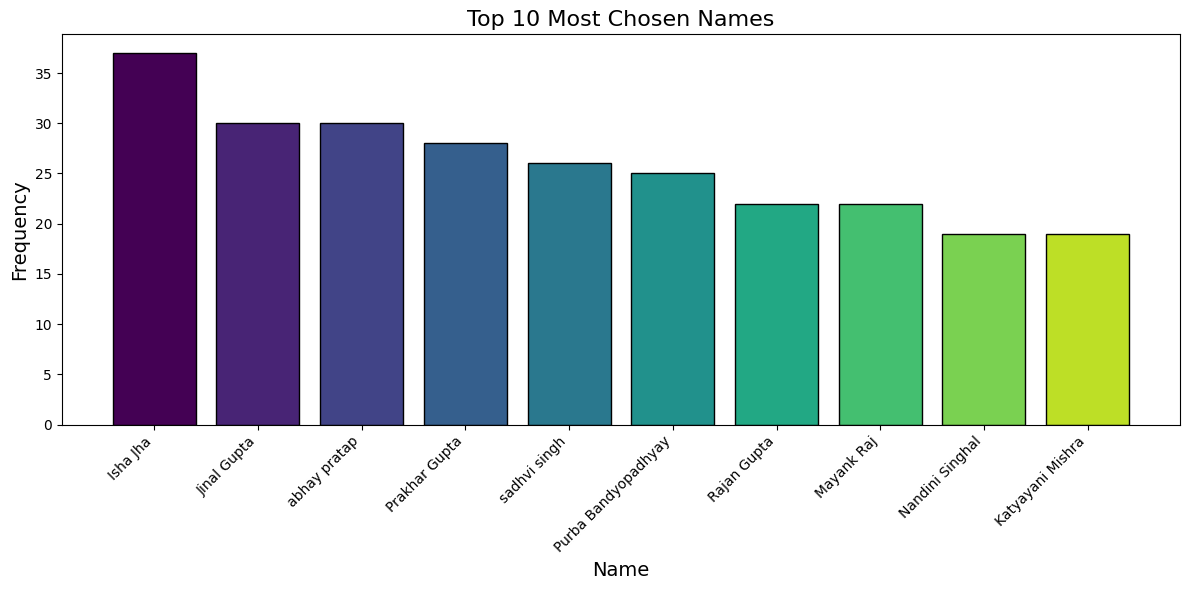

In [101]:
# 1. Bar Chart - Frequency of Chosen Names

plt.figure(figsize=(12, 6))
ax = plt.gca()  # Get current axes
x_labels = name_frequency.head(10).index
y_values = name_frequency.head(10).values
gradient_bar(ax, x_labels, y_values)
plt.title('Top 10 Most Chosen Names', fontsize=16)
plt.xlabel('Name', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()



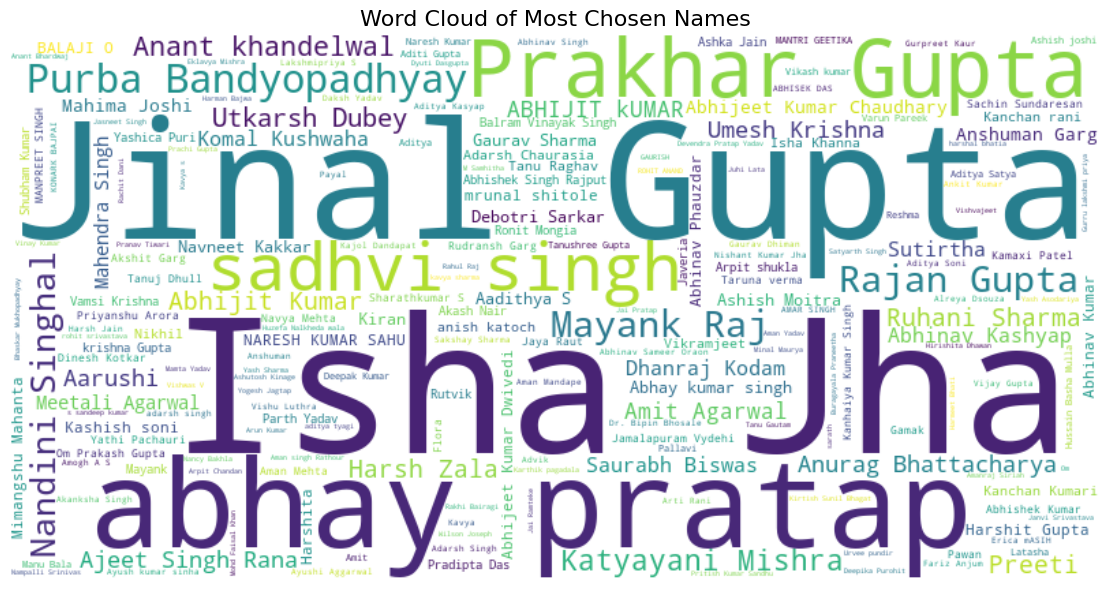

In [102]:

# 2. Word Cloud - Most Chosen Names
wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='viridis').generate_from_frequencies(name_frequency)

plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Most Chosen Names', fontsize=16)
plt.tight_layout()
plt.show()

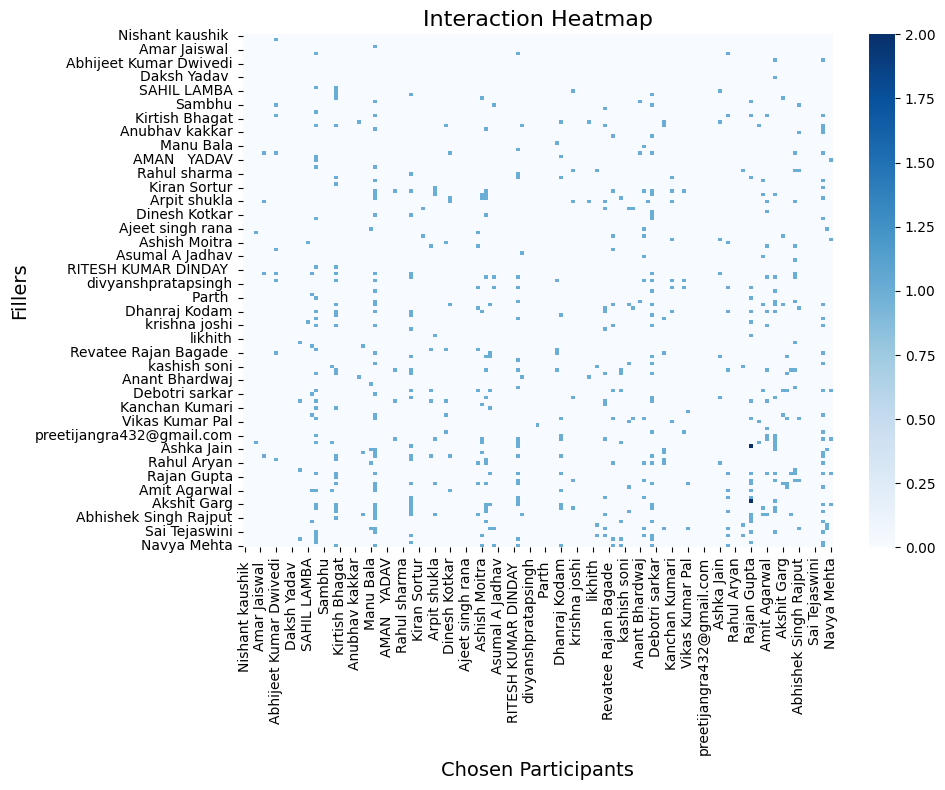

In [103]:
# 3. Heatmap - Interaction Matrix
# Create an adjacency matrix
participants = zoomdf_cleaned['Name'].tolist()
matrix = pd.DataFrame(0, index=participants, columns=participants)
# print(participants)
# print(matrix)
for _, row in zoomdf_cleaned.iterrows():
    for chosen_name in row['Chosen Names']:  
        if chosen_name in matrix.columns:
            matrix.loc[row['Name'], chosen_name] += 1

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(matrix, cmap='Blues', annot=False, cbar=True)
plt.title('Interaction Heatmap', fontsize=16)
plt.xlabel('Chosen Participants', fontsize=14)
plt.ylabel('Fillers', fontsize=14)
plt.tight_layout()
plt.show()


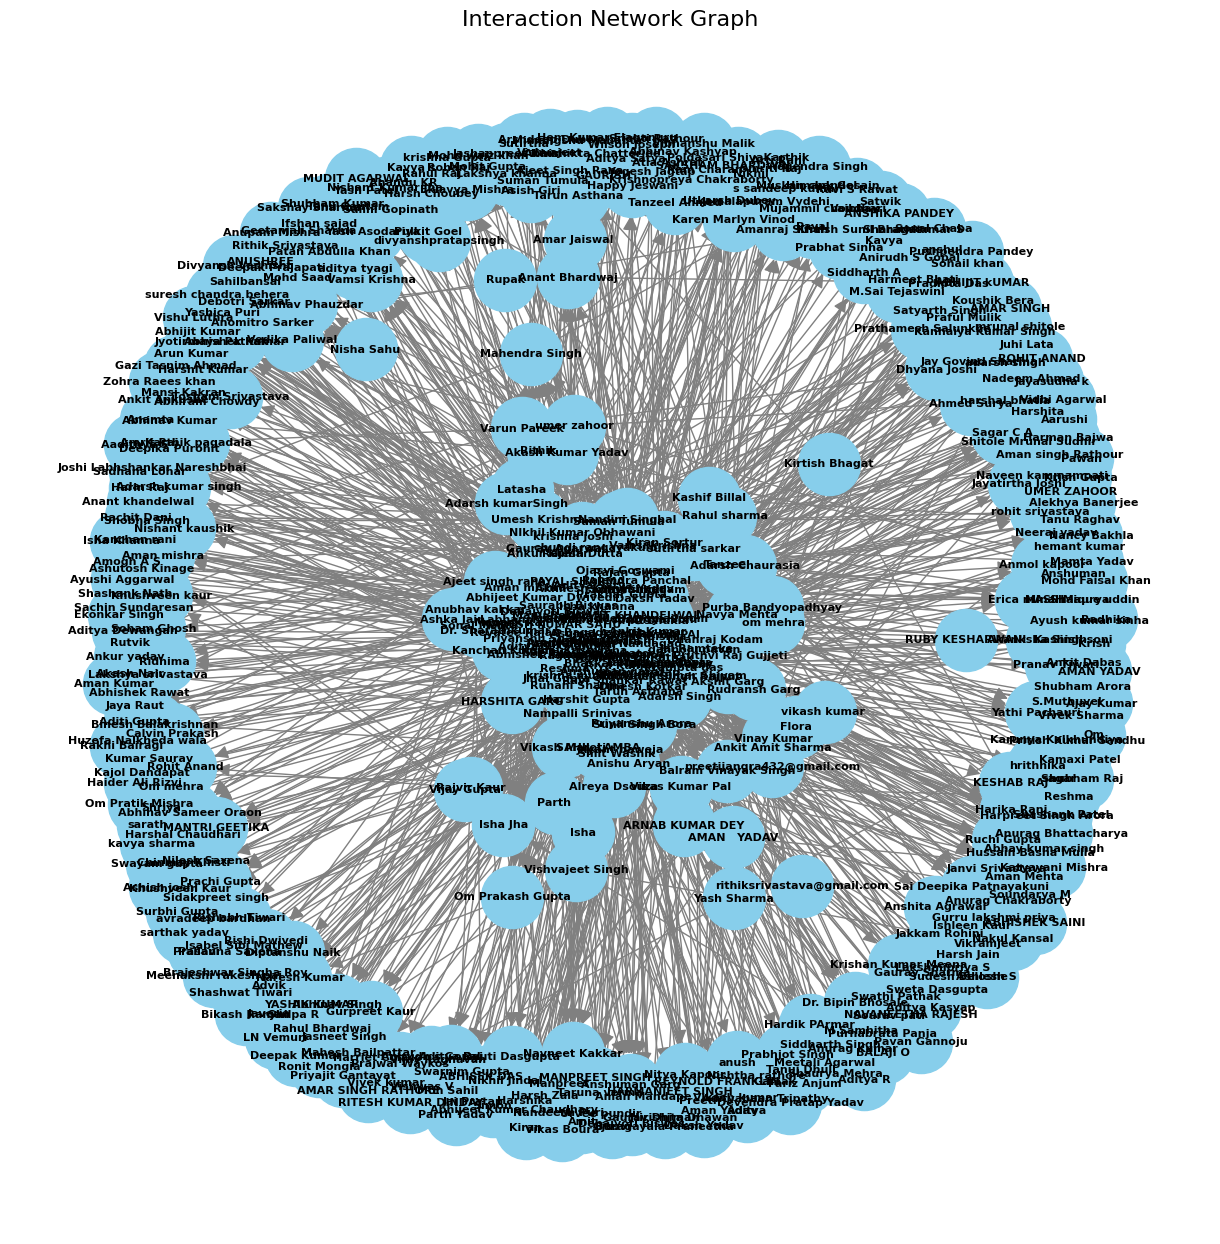

In [104]:
# Graph Analysis 
#Step 1: Build the Interaction Network Graph
# Create a directed graph using NetworkX
G = nx.DiGraph()

# Add edges to the graph (from filler name to chosen names)
for _, row in zoomdf_cleaned.iterrows():
    filler = row['Name']
    chosen_names = row['Chosen Names']
    for chosen_name in chosen_names:
        G.add_edge(filler, chosen_name)

# Graph Analysis Step 2: Visualize the Interaction Network
plt.figure(figsize=(12, 12))
pos = nx.spring_layout(G, seed=42)  # Positioning nodes
nx.draw(
    G, pos, with_labels=True, node_color='skyblue', node_size=2000,
    edge_color='gray', font_size=8, font_weight='bold', arrowsize=20
)
plt.title('Interaction Network Graph', fontsize=16)
plt.show()

In [105]:
# Graph Analysis Step 3: Degree Centrality Analysis
degree_centrality = nx.degree_centrality(G)
sorted_centrality = sorted(degree_centrality.items(), key=lambda x: x[1], reverse=True)[:10]
print(sorted_centrality)

[('abhay pratap', 0.11958762886597939), ('sadhvi singh', 0.11134020618556702), ('Mayank Raj', 0.10515463917525773), ('Jinal Gupta', 0.10103092783505155), ('Umesh Krishna', 0.09278350515463918), ('Isha Jha', 0.08453608247422681), ('Harshit Gupta', 0.08041237113402062), ('Saurabh Biswas', 0.07835051546391752), ('Priyanshu Arora', 0.07422680412371134), ('Ashish Moitra', 0.07216494845360825)]


In [106]:
# Display the top 10 participants with the highest degree centrality
print("Top 10 Participants by Degree Centrality:")
for name, centrality in sorted_centrality:
    print(f"{name}: {centrality:.4f}")

Top 10 Participants by Degree Centrality:
abhay pratap: 0.1196
sadhvi singh: 0.1113
Mayank Raj: 0.1052
Jinal Gupta: 0.1010
Umesh Krishna: 0.0928
Isha Jha: 0.0845
Harshit Gupta: 0.0804
Saurabh Biswas: 0.0784
Priyanshu Arora: 0.0742
Ashish Moitra: 0.0722


In [107]:
# Graph Analysis Step 4: Community Detection (Using Louvain method for modularity-based communities)

communities = greedy_modularity_communities(G.to_undirected())  # Use undirected graph for community detection
print("\nCommunities Detected:")
for i, community in enumerate(communities):
    print(f"Community {i+1}: {list(community)}")




Communities Detected:
Community 1: ['Rahul Bhardwaj', 'Akshit Garg', 'Latasha', 'Vamsi Krishna', 'Akash Kumar Yadav', 'Soham Ghosh', 'Aditya Satya ', 'Naresh Kumar', 'Katyayani Mishra', 'sarath', 'Javeria', 'Aman Mehta', 'Saurabh Biswas', 'Akash Nair', 'abhay pratap', 'Anomitro Sarker', 'Siddharth A', 'Naveen kammampati', 'Mahima Joshi', 'Priyanshu Arora', 'hemant kumar', 'Navya Mehta', 'Navneet Kakkar', 'Umesh Krishna', 'Isha Jha', 'Balram Vinayak Singh', 'Diptanshu Naik', 'Tanu Gautam', 'Yathi Pachauri', 'Pradipta das', 'Prakhar Gupta', 'KONARK BAJPAI', 'preetijangra432@gmail.com', 'Hem Kumar Elaganuru', 'Tarun Asthana ', 'Anshuman', 'Bhaskar Mukhopadhyay', 'sutirtha sarkar', 'Purnabrata Panja', 'Alreya Dsouza', 'Mamta Yadav', 'Poldasari ShivaKarthik', 'krishna joshi', 'Komal Kushwaha', 'Rudransh Garg', 'Prathamesh Salunkhe', 'Ojasvi Goswami', 'Abhishek Singh Rajput', 'Suman Tumula', 'AMAN   YADAV', 'om mehra', 'Sohail khan', 'Ravi S Rawat', 'Shubham Kumar Shivam', 'Ishleen Kaur', '

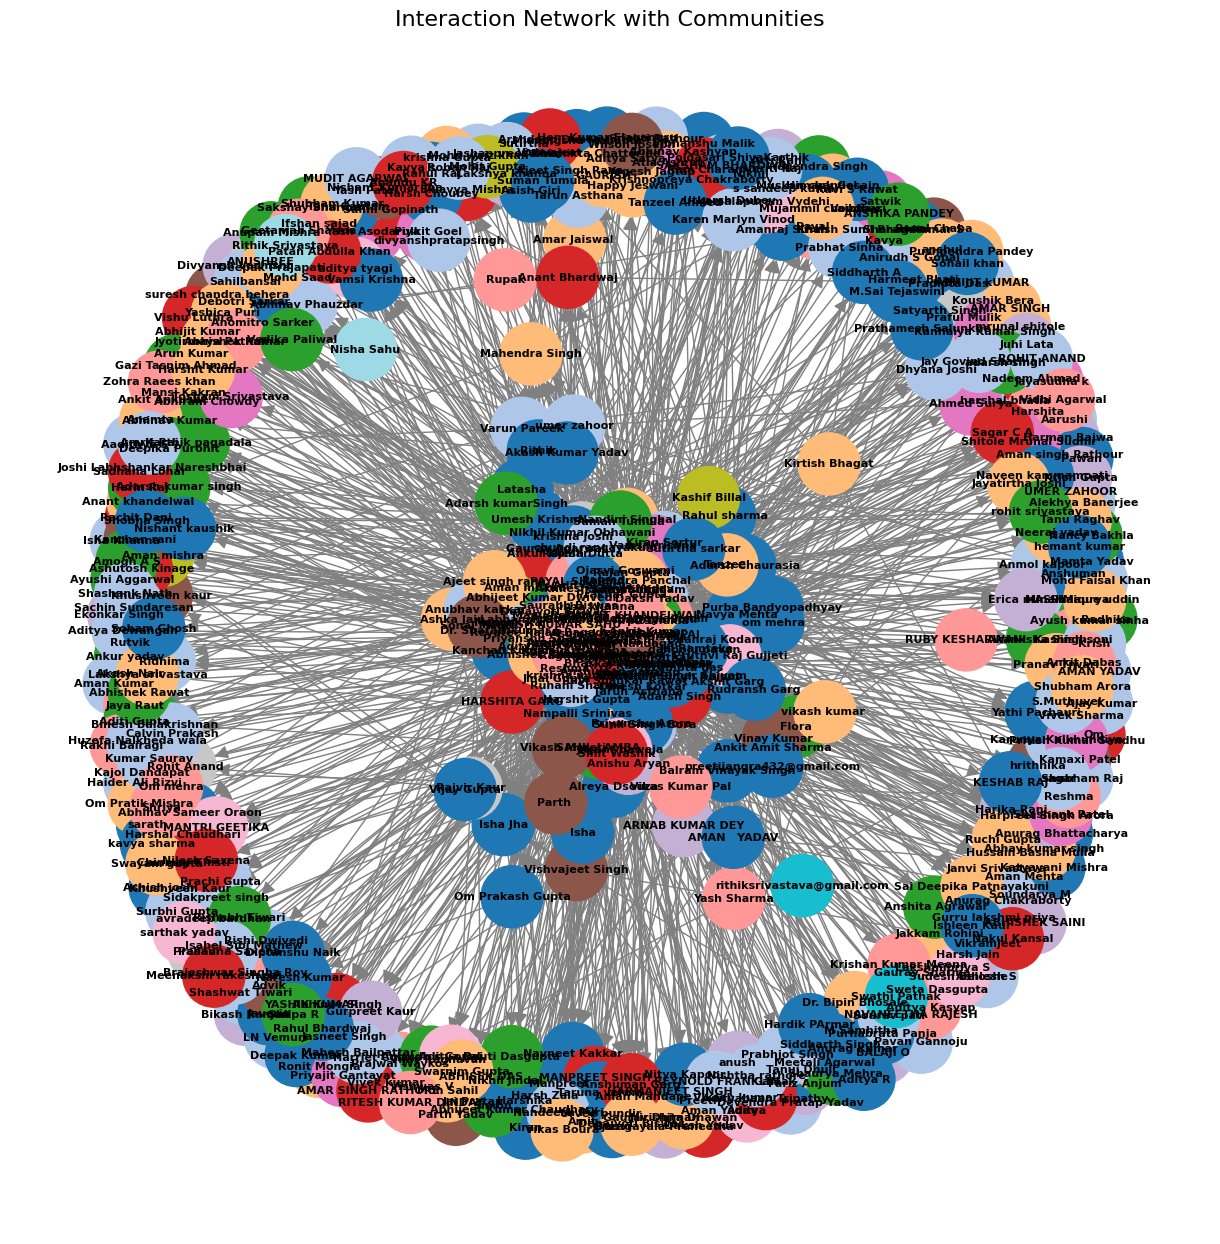

In [108]:
# Visualize communities with color coding
color_map = {}
for i, community in enumerate(communities):
    for name in community:
        color_map[name] = i

node_colors = [color_map[node] for node in G.nodes]
plt.figure(figsize=(12, 12))
nx.draw(
    G, pos, with_labels=True, node_color=node_colors, node_size=2000,
    edge_color='gray', font_size=8, font_weight='bold', arrowsize=20,
    cmap=plt.cm.tab20  # Use a colormap for coloring
)
plt.title('Interaction Network with Communities', fontsize=16)
plt.show()

### #---------------------- Participant Interaction Metrics ----------------------#

In [109]:
# Step 1: Interaction Frequency
# Calculate the total number of interactions for each participant
interaction_frequency = matrix.sum(axis=1)  # Total interactions per filler (row-wise sum)
print("Interaction Frequency for each participant:")
print(interaction_frequency)

Interaction Frequency for each participant:
Nishant kaushik      0
Aman mishra          1
Rupak                0
Vishvajeet Singh     1
Amar Jaiswal         0
                    ..
Sai Tejaswini        5
ANANT KHANDELWAL     9
abhay pratap         6
Ankit Kumar          4
Navya Mehta         11
Length: 149, dtype: int64


In [110]:
# Step 2: Top Interactors
# Combine incoming and outgoing interactions for ranking
total_interactions = interaction_frequency + matrix.sum(axis=0)  # Add outgoing and incoming
top_interactors = total_interactions.sort_values(ascending=False).head(10)
print("\nTop 10 Interactors:")
print(top_interactors)


Top 10 Interactors:
Jinal Gupta            42
Isha Jha               38
abhay pratap           36
sadhvi singh           33
Prakhar Gupta          32
Mayank Raj             32
Purba Bandyopadhyay    29
Nandini Singhal        26
Rajan Gupta            25
Komal Kushwaha         25
dtype: int64


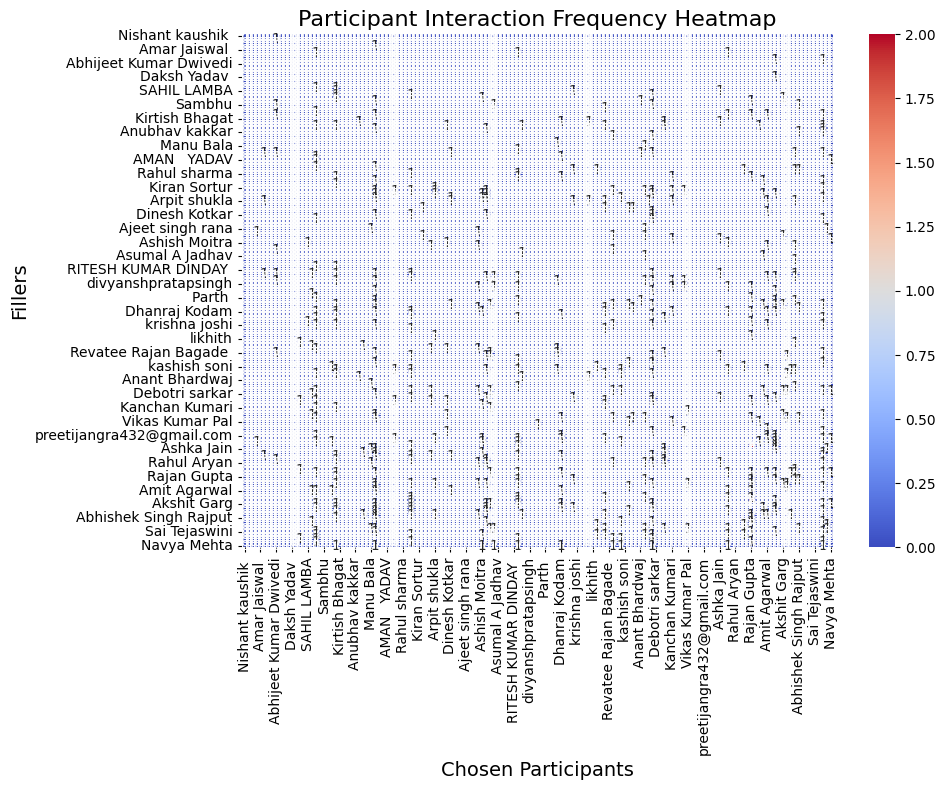

In [111]:
# Step 3: Heatmap - Interaction Frequency
plt.figure(figsize=(10, 8))
sns.heatmap(matrix, cmap='coolwarm', annot=True, fmt='d', cbar=True)
plt.title('Participant Interaction Frequency Heatmap', fontsize=16)
plt.xlabel('Chosen Participants', fontsize=14)
plt.ylabel('Fillers', fontsize=14)
plt.tight_layout()
plt.show()

In [ ]:
# To Be Continued ...